# Part 2: SVM - Question 2

This notebook is dedicated to training and evaluating a nonlinear Support Vector Machine (SVM) model for a binary gender classification task. Our goal is to explore how different kernel choices and hyperparameter settings influence the performance of the classifier, while solving the dual optimization problem associated with SVMs.

To achieve this, we will experiment with the **Polynomial** kernel and the **Gaussian (RBF)**. The optimization of the dual SVM objective will be performed using the convex solver provided by **CVXOPT**.

To ensure robust and fair model selection, we will apply **5-fold cross-validation** to tune the relevant hyperparameters, namely the regularization parameter $C$ and either the kernel exponent $p$ (for the polynomial kernel) or the bandwidth parameter $\gamma$ (for the Gaussian kernel).

Finally, we will evaluate the model by reporting the classification accuracy on both the training and test sets, analyzing the confusion matrix for a more detailed error breakdown and recording optimization-related statistics such as the time required for training, the number of iterations performed by the solver and the final value of the dual objective function.


##  Importing required libraries and custom modules

In [1]:
import importlib
import Functions_22_Avino_Lombardi
importlib.reload(Functions_22_Avino_Lombardi)
from Functions_22_Avino_Lombardi import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns

## Data Loading and Preparation

In this section, we import the dataset and prepare it for model training.

The dataset is first read into a pandas DataFrame and inspected to verify its structure and the class distribution. The feature matrix `X` is extracted as all columns **except the last one**, while the label vector `y` is taken from the **last column**.

Since the original dataset encodes the target class as `0` for one group and `1` for the other, we explicitly recode the labels to match the SVM convention: **−1 for class 0**, and **+1 for class 1**. This transformation is done using `np.where`, which replaces every 0 with −1 and keeps 1 unchanged.

Next, the dataset is split into a training set and a test set, using an **80/20 stratified split**. 

Before training, we standardize the input features using `StandardScaler`. This transformation ensures that each feature has zero mean and unit variance, which is essential for SVMs. Without this normalization, features with larger numeric ranges could dominate the computation of the decision boundary, leading to suboptimal performance.

### Loading the dataset

In [2]:
data = pd.read_csv("../dataset/GENDER_CLASSIFICATION.csv")
data.head()

,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,feat_8,feat_9,feat_10,...,feat_24,feat_25,feat_26,feat_27,feat_28,feat_29,feat_30,feat_31,feat_32,gt
0,-0.900846,0.102587,-0.397814,0.112796,2.588096,-0.192754,-0.968311,-0.490886,-0.872099,-0.288411,...,2.541431,1.739102,0.166066,4.584869,-0.107031,-0.913990,-0.686416,-0.368085,-0.870545,0
1,-0.838868,0.039976,-0.387101,0.055413,2.066874,-0.226948,-0.947416,-0.472817,-0.855387,-0.207101,...,1.991721,1.259745,0.065058,3.019790,-0.110633,-0.890023,-0.611625,-0.298235,-0.855208,0
2,-0.814961,-0.010184,-0.397147,0.092713,1.897454,-0.269387,-0.945285,-0.449579,-0.849705,-0.151179,...,1.822978,1.105511,0.065353,2.500681,-0.052730,-0.885691,-0.583346,-0.218140,-0.856456,0
3,-0.110470,0.027849,-0.044310,-0.005343,0.177831,-0.232092,-0.562700,-0.400713,-0.552356,0.037349,...,-0.098367,-0.370318,-0.123008,-0.861314,0.106840,-0.483669,-0.224164,0.147321,-0.615051,0
4,-0.626313,-0.091985,-0.373756,-0.005083,1.172486,-0.314868,-0.885046,-0.412587,-0.818729,-0.012022,...,1.030348,0.421886,-0.068029,0.258984,-0.057158,-0.834079,-0.441066,-0.099874,-0.829539,0


### Inspecting the dataset

In [3]:
# Check basic information
print("Shape:", data.shape)
print("\nColumns:", data.columns.tolist())
print("\nClass distribution:\n", data["gt"].value_counts())

Shape: (1000, 33)

Columns: ['feat_1', 'feat_2', 'feat_3', 'feat_4', 'feat_5', 'feat_6', 'feat_7', 'feat_8', 'feat_9', 'feat_10', 'feat_11', 'feat_12', 'feat_13', 'feat_14', 'feat_15', 'feat_16', 'feat_17', 'feat_18', 'feat_19', 'feat_20', 'feat_21', 'feat_22', 'feat_23', 'feat_24', 'feat_25', 'feat_26', 'feat_27', 'feat_28', 'feat_29', 'feat_30', 'feat_31', 'feat_32', 'gt']

Class distribution:
 gt
0    500
1    500
Name: count, dtype: int64


### Extracting Features and Recoding Labels

In [4]:
X = data.iloc[:, :-1].values
y = np.where(data.iloc[:, -1].values == 0, -1, 1)
print("Unique labels after conversion:", np.unique(y))

Unique labels after conversion: [-1  1]


### Splitting the dataset

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=1234)

### Standardizing the features

In [6]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Training and Evaluation: Polynomial Kernel

We now proceed to train and evaluate the model using the **Polynomial kernel**.

The polynomial kernel introduces nonlinearity by computing the similarity between input vectors using polynomial combinations of the original features. It is defined as:

$$
K(x, y) = (x^\top y + 1)^p
$$

This formulation allows the SVM to learn curved decision boundaries in the original feature space, depending on the degree of the polynomial $p$.

The hyperparameters involved are:
- $C$, the regularization parameter, which balances the trade-off between margin maximization and classification error minimization;
- $p$. the degree of the polynomial, which controls the flexibility of the decision boundary.

In this experiment, we will test values of $C$ ranging from $1$ to $10$ and values of $p$ $\in \{2, 3, 4\}$.


In [7]:
# Set kernel and grid
polynomial_kernel_func = polynomial_kernel
polynomial_param_name = "p"
polynomial_grid = {"C": list(range(1, 11)), "p": [2, 3, 4]}

### Performing Cross-Validation
To select the best combination of hyperparameters, we perform 5-fold cross-validation. 

This procedure splits the training set into five folds, trains on four and validates on the fifth, rotating folds to obtain an average validation accuracy for each parameter combination.

In [8]:
# Perform cross-validation
polynomial_params_comb, polynomial_val_acc = crossval_svm(
    X=X_train,
    y=y_train,
    k=5,
    grid=polynomial_grid,
    kernel_func=polynomial_kernel_func,
    kernel_param_name=polynomial_param_name,
    use_seed=True
)

# Extract best parameters
polynomial_best_idx = int(np.argmax(polynomial_val_acc))
polynomial_best_params = polynomial_params_comb[polynomial_best_idx]
polynomial_best_C = polynomial_best_params["C"]
polynomial_best_kernel_param = polynomial_best_params[polynomial_param_name]

### Final Training, Evaluation and Reporting
With the best hyperparameters found through cross-validation, we retrain the SVM on the entire training set and evaluate its performance on both training and test sets.

We also report:
- Optimization time and number of iterations;
- Final value of the dual objective;
- Confusion matrix on the test set.


FINAL REPORT POLYNOMIAL KERNEL


,KERNEL,C,p,TRAIN ACCURACY,TEST ACCURACY,NUMBER OF ITERATIONS,CPU TIME (s),DUAL OBJ VALUE
0,polynomial_kernel,1,2,0.92,0.905,15,1.6032,-126.227


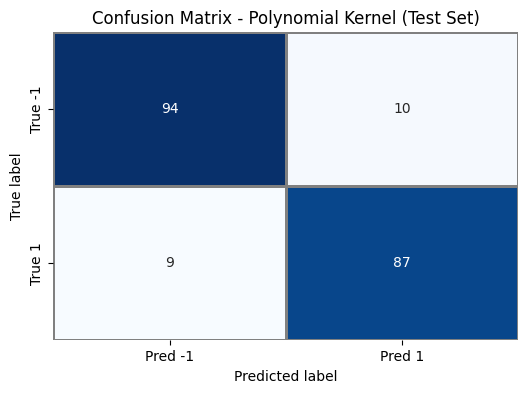

In [9]:
# Train final model
polynomial_model = SVM(C=polynomial_best_C, kernel_func=polynomial_kernel_func, kernel_params={polynomial_param_name: polynomial_best_kernel_param})
polynomial_model.fit(X_train, y_train)

# Make predictions
polynomial_y_train_pred = polynomial_model.predict(X_train)
polynomial_y_test_pred = polynomial_model.predict(X_test)

# Compute accuracies
polynomial_train_acc = compute_accuracy(y_train, polynomial_y_train_pred)
polynomial_test_acc = compute_accuracy(y_test, polynomial_y_test_pred)

# Build report
polynomial_df_report = pd.DataFrame([{
    "KERNEL": polynomial_kernel_func.__name__,
    "C": polynomial_best_C,
    polynomial_param_name: polynomial_best_kernel_param,
    "TRAIN ACCURACY": round(polynomial_train_acc, 4),
    "TEST ACCURACY": round(polynomial_test_acc, 4),
    "NUMBER OF ITERATIONS": polynomial_model.last_num_iter,
    "CPU TIME (s)": round(polynomial_model.last_cpu_time, 4),
    "DUAL OBJ VALUE": round(polynomial_model.dual_objective(), 4)
}])

print("\nFINAL REPORT POLYNOMIAL KERNEL")
display(polynomial_df_report)

# Confusion matrix
polynomial_conf_matrix = compute_confusion_matrix(y_test, polynomial_y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(polynomial_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            linewidths=1, linecolor='gray')
plt.title("Confusion Matrix - Polynomial Kernel (Test Set)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

## Training and Evaluation: Gaussian (RBF) Kernel

We now turn to the Gaussian kernel, also known as the Radial Basis Function (RBF) kernel. Just like in the polynomial case, we will perform three steps: defining the hyperparameter grid, running cross-validation and training the final model on the best configuration.

The Gaussian kernel introduces nonlinearity by mapping the input features into an infinite-dimensional space, where the decision boundary can become highly flexible. It is defined as:

$$
K(x, y) = \exp(-\gamma \|x - y\|^2)
$$

The hyperparameters involved are:
- $C$, the regularization parameter that controls the trade-off between maximizing the margin and minimizing classification errors;
- $gamma$, the kernel coefficient that defines how much influence a single training example has. Smaller values result in a broader influence, while larger values lead to tighter, more localized decision boundaries.

In this experiment, we will try values of $C$ ranging from $1$ to $10$ and values of $\gamma$ equal to $0.1$, $0.5$ and $1$.

In [10]:
gaussian_kernel_func = gaussian_kernel
gaussian_param_name = "gamma"
gaussian_grid = {"C": list(range(1, 11)), "gamma": [0.1, 0.5, 1]}

### Performing Cross-Validation

In [11]:
# Perform cross-validation
gaussian_params_comb, gaussian_val_acc = crossval_svm(
    X=X_train,
    y=y_train,
    k=5,
    grid=gaussian_grid,
    kernel_func=gaussian_kernel_func,
    kernel_param_name=gaussian_param_name,
    use_seed=True
)

# Extract best parameters
gaussian_best_idx = int(np.argmax(gaussian_val_acc))
gaussian_best_params = gaussian_params_comb[gaussian_best_idx]
gaussian_best_C = gaussian_best_params["C"]
gaussian_best_kernel_param = gaussian_best_params[gaussian_param_name]

### Final Training, Evaluation and Reporting


FINAL REPORT GAUSSIAN KERNEL


,KERNEL,C,gamma,TRAIN ACCURACY,TEST ACCURACY,NUMBER OF ITERATIONS,CPU TIME (s),DUAL OBJ VALUE
0,gaussian_kernel,1,0.1,0.9212,0.91,14,1.2193,-135.4057


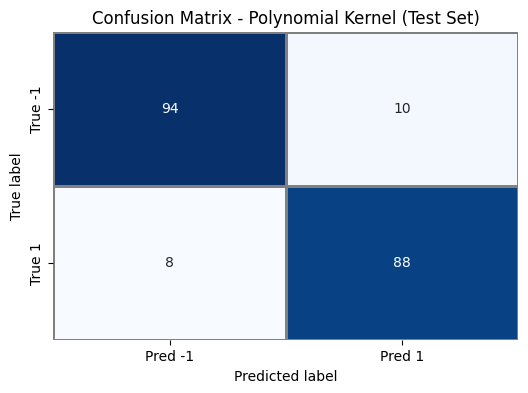

In [12]:
# Train final model
gaussian_model = SVM(C=gaussian_best_C, kernel_func=gaussian_kernel_func, kernel_params={gaussian_param_name: gaussian_best_kernel_param})
gaussian_model.fit(X_train, y_train)

# Make predictions
gaussian_y_train_pred = gaussian_model.predict(X_train)
gaussian_y_test_pred = gaussian_model.predict(X_test)

# Compute accuracies
gaussian_train_acc = compute_accuracy(y_train, gaussian_y_train_pred)
gaussian_test_acc = compute_accuracy(y_test, gaussian_y_test_pred)

# Build report
gaussian_df_report = pd.DataFrame([{
    "KERNEL": gaussian_kernel_func.__name__,
    "C": gaussian_best_C,
    gaussian_param_name: gaussian_best_kernel_param,
    "TRAIN ACCURACY": round(gaussian_train_acc, 4),
    "TEST ACCURACY": round(gaussian_test_acc, 4),
    "NUMBER OF ITERATIONS": gaussian_model.last_num_iter,
    "CPU TIME (s)": round(gaussian_model.last_cpu_time, 4),
    "DUAL OBJ VALUE": round(gaussian_model.dual_objective(), 4)
}])

print("\nFINAL REPORT GAUSSIAN KERNEL")
display(gaussian_df_report)

# Confusion matrix
gaussian_conf_matrix = compute_confusion_matrix(y_test, gaussian_y_test_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(gaussian_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            linewidths=1, linecolor='gray')
plt.title("Confusion Matrix - Polynomial Kernel (Test Set)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()